# Exploring DSC SET Data

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Data Loading/Cleaning
In this section we load and merge the data for EDA

*Load and clean SETs Data*

In [131]:
# load sets into dataframe
dsc_sets = pd.read_csv('datasets/dsc_sets.csv')

# merge duplicate columns
dsc_sets["Enrolled Resp Rate"] = dsc_sets["Enrolled/ Resp Rate"].fillna(dsc_sets["Enrolled/  Resp Rate"])
dsc_sets = dsc_sets.drop(columns=["Enrolled/ Resp Rate", "Enrolled/  Resp Rate"])

# rename columns for easier access
dsc_sets.columns = dsc_sets.columns.str.replace('*', '', regex=False)
dsc_sets.columns = dsc_sets.columns.str.replace(' ', '_')
dsc_sets['Term'] = dsc_sets['Term'].str.lower()


# Extract the number before the parentheses
dsc_sets['Enrolled_Resp_Number'] = dsc_sets['Enrolled_Resp_Rate'].str.extract(r'(\d+)\s*\(')[0].astype(int)
# Extract the percentage inside parentheses
dsc_sets['Enrolled_Resp_Pct'] = dsc_sets['Enrolled_Resp_Rate'].str.extract(r'\(([\d\.]+)%\)')[0].astype(float)

# remove Letter from Avg Grade Received
dsc_sets["Avg_Grade_Received"] = (
    dsc_sets["Avg_Grade_Received"]
    .str.extract(r'(\d+\.\d+|\d+)')   # extract first number
    .astype(float)
)

# delete unnecessary columns
dsc_sets = dsc_sets.drop(columns=["Course", "Enrolled_Resp_Rate"])
# remove dsc96 course (doesn't have grades)
dsc_sets = dsc_sets[dsc_sets['course_title'] != 'dsc95']

dsc_sets = dsc_sets.dropna(subset=['Avg_Grade_Received'])
dsc_sets.head()

,Instructor,Term,Avg_Grade_Received,Avg_Hours_Worked,Learning_Average,Structure_Average,Environment_Average,course_title,Enrolled_Resp_Number,Enrolled_Resp_Pct
0,"Bellur, Umesh",wi25,3.93,9.93,3.74,3.55,4.12,dsc180b,114,14.04
1,"Bellur, Umesh",wi25,3.99,11.89,4.02,3.74,3.80,dsc180b,118,16.95
2,"Rampure, Suraj",wi24,3.96,9.60,4.60,4.59,4.58,dsc180b,97,10.31
3,"Rampure, Suraj",wi24,3.99,6.23,4.57,4.57,4.53,dsc180b,138,9.42
4,"Weng, Tsui-Wei (lily)",sp25,3.71,7.38,4.19,4.13,4.24,dsc140b,124,45.16


*Merge SETs data with Utilization Rate from WebReg Data*

In [132]:
webreg_data = pd.read_csv('webreg_data/results/webreg_processed_data.csv')
webreg_data.head()
merged_data = webreg_data[['course', 'quarter', 'utilization_rate']]
merged_data = merged_data.copy()

#drop underscore from course column to match dsc_sets
merged_data['course'] = merged_data['course'].str.replace('_', '').str.lower()
merged_data = merged_data.rename(columns={'course': 'course_title', 'quarter': 'Term'})
# merge datasets on course title and term
final_data = pd.merge(dsc_sets, merged_data, on=['course_title', 'Term'], how='inner')
cols = ['course_title'] + [c for c in final_data.columns if c != 'course_title']
final_data = final_data[cols]

final_data.head()

,course_title,Instructor,Term,Avg_Grade_Received,Avg_Hours_Worked,Learning_Average,Structure_Average,Environment_Average,Enrolled_Resp_Number,Enrolled_Resp_Pct,utilization_rate
0,dsc180b,"Bellur, Umesh",wi25,3.93,9.93,3.74,3.55,4.12,114,14.04,98.30
1,dsc180b,"Bellur, Umesh",wi25,3.99,11.89,4.02,3.74,3.80,118,16.95,98.30
2,dsc140b,"Weng, Tsui-Wei (lily)",sp25,3.71,7.38,4.19,4.13,4.24,124,45.16,97.62
3,dsc140b,"Huang, Biwei",wi25,3.53,6.38,4.25,4.27,4.57,42,30.95,29.66
4,dsc100,"Salimi, Babak",sp25,3.63,5.44,4.04,3.61,4.05,139,74.10,92.47


## EDA of SETs + Utilization Data

### Correlation of Numeric Course Metrics
This visualization shows the pairwise linear correlations among key numeric course metrics in the dataset, focusing on the lower triangle of the correlation matrix to avoid redundancy.

The variables included are:
* Avg_Grade_Received – average grade students earned in the course
* Avg_Hours_Worked – average weekly hours students reported spending on the course
* Learning_Average – students’ evaluation of how much they learned
* Structure_Average – students’ evaluation of the course’s organization and clarity
* Environment_Average – students’ evaluation of the classroom and learning environment
* Enrolled_Resp_Number – number of students enrolled/responded
* Enrolled_Resp_Pct – enrollment/response percentage

`Structure_Average`, `Learning_Average`, and `Environment_Average` exhibit strong positive correlations, indicating consistent student perceptions across these aspects.

In [133]:
numeric_cols = ['Avg_Grade_Received', 'Avg_Hours_Worked',
                'Learning_Average', 'Structure_Average', 
                'Environment_Average', 'Enrolled_Resp_Number',
                'Enrolled_Resp_Pct']
numeric_df = final_data[numeric_cols]

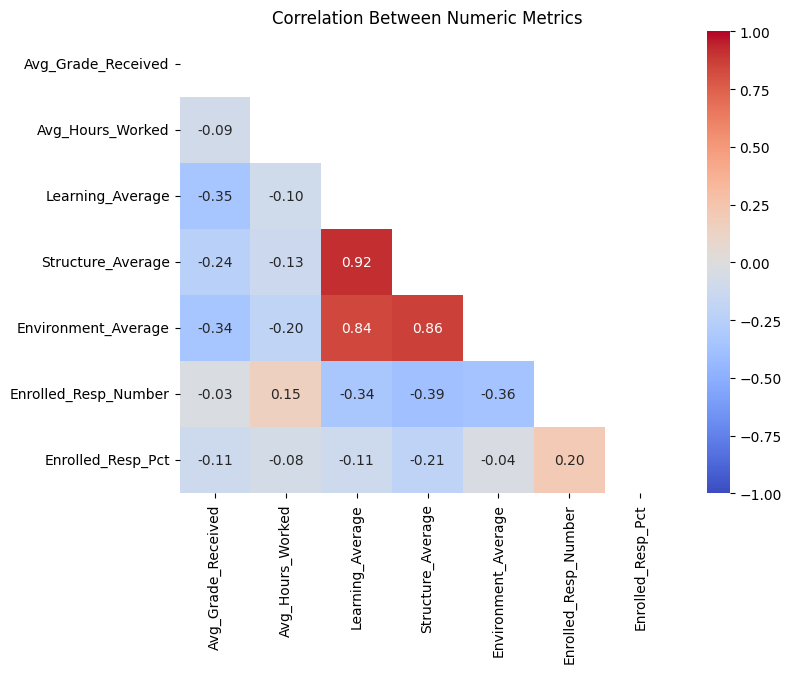

In [134]:
corr = numeric_df.corr()
plt.figure(figsize=(8,6))  # set figure size
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr,
    annot=True,       # show correlation values
    fmt=".2f",        # format numbers
    cmap='coolwarm',  # color map
    vmin=-1, vmax=1,   # fix color scale
    mask=mask      # hide diagonal
)
plt.title("Correlation Between Numeric Metrics")
plt.show()

### Test 1: Test for Multi-Colinearity

**Purpose**: Determine if numeric predictors are highly correlated, which can inflate regression coefficients and make them unstable.

**Testing**: 
* **Coefficient**: Change in `utilization_rate` for a one-unit increase in predictor.
* **p-value**: If predictor's effect is significantly associated with `utilization_rate` (is if \< 0.05)
* **$R^2$**: Proportion of variance in `utilization_rate` explained by the predictor alone.


In [140]:
X = numeric_df.dropna() 
X = sm.add_constant(X) 
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,feature,VIF
0,const,996.951304
1,Avg_Grade_Received,1.309282
2,Avg_Hours_Worked,1.100875
3,Learning_Average,7.520355
4,Structure_Average,9.536792
5,Environment_Average,4.856785
6,Enrolled_Resp_Number,1.249750
7,Enrolled_Resp_Pct,1.206745


### Test 2: Simple Linear Regression of Numeric Predictors on Utilization Rate

**Purpose**: Find if any numeric variables predict `utilization_rate` in a univariate model.

**Testing**: 
* **Coefficient**: Change in `utilization_rate` for a one-unit increase in predictor.
* **p-value**: If predictor's effect is significantly associated with `utilization_rate` (is if \< 0.05)
* **$R^2$**: Proportion of variance in `utilization_rate` explained by the predictor alone.


In [141]:
results = []

for col in numeric_cols:
    X = final_data[[col]]
    Y = final_data['utilization_rate']
    
    # Add constant for intercept
    X = sm.add_constant(X)
    
    # Fit model
    model = sm.OLS(Y, X).fit()
    
    # Save results
    results.append({
        'Predictor': col,
        'Coefficient': model.params[col],
        'Intercept': model.params['const'],
        'R_squared': model.rsquared,
        'p_value': model.pvalues[col]
    })

# Convert to DataFrame for easy viewing
regression_results = pd.DataFrame(results)
print(regression_results)

              Predictor  Coefficient   Intercept  R_squared   p_value
0    Avg_Grade_Received     8.721208   50.218312   0.045302  0.099580
1      Avg_Hours_Worked     0.986878   72.213639   0.014111  0.361866
2      Learning_Average    -6.445470  107.707438   0.018090  0.301401
3     Structure_Average   -11.990614  130.222766   0.070799  0.038201
4   Environment_Average   -17.965713  159.984205   0.077289  0.030055
5  Enrolled_Resp_Number     0.178622   62.620848   0.335441  0.000001
6     Enrolled_Resp_Pct     0.117170   74.025213   0.030149  0.180810


**Interpretation**: 
* **Coefficient**: Change in `utilization_rate` for a one-unit increase in predictor.
* **p-value**: If predictor's effect is significantly associated with `utilization_rate` (is if \< 0.05)
* **$R^2$**: Proportion of variance in `utilization_rate` explained by the predictor alone.
